In [87]:
import spectral.io.envi as envi
from spectral import imshow
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
#все функции внизу

In [66]:
open_hsi = envi.open(r'C:\Users\konst\jupyter notebook\HSI\data envil\jasperRidge2_F224.hdr',
                     r'C:\Users\konst\jupyter notebook\HSI\data envil\jasperRidge2_F224.img')
hsi = np.array(open_hsi.open_memmap())
print(hsi.shape)

(100, 100, 224)


(100, 100, 3)
(10000, 3)


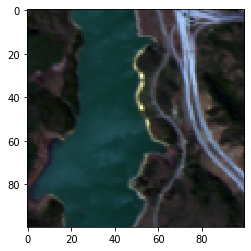

In [169]:
RGB_hsi = imshow(hsi, (35, 20, 7)) # 35, 20, 7 - каналы наиболее близки к видимому спектру RGB
RGB_hsi = np.array(RGB_hsi.data_rgb)
print(RGB_hsi.shape)
line_RGB_hsi = np.float64(RGB_hsi.reshape( (-1, RGB_hsi.shape[2]) )) * 255
print(line_RGB_hsi.shape)

In [178]:
line_hsi = hsi.reshape( (-1, hsi.shape[2]) )

In [179]:
mask_hsi, color_mask_hsi, cluster_hsi, mask_values = reference_clustering(line_hsi, 0.95, value_mask_on = True, rgb_image = line_RGB_hsi)

10000
9000

nclass 18


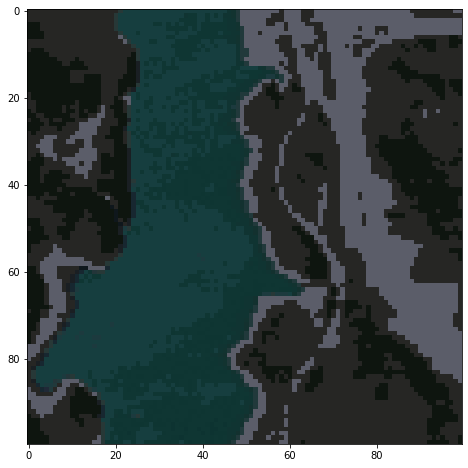

In [193]:
plt.figure(figsize = (8, 8))
plt.imshow( color_mask_hsi.reshape(open_hsi.ncols, open_hsi.ncols, 3) )

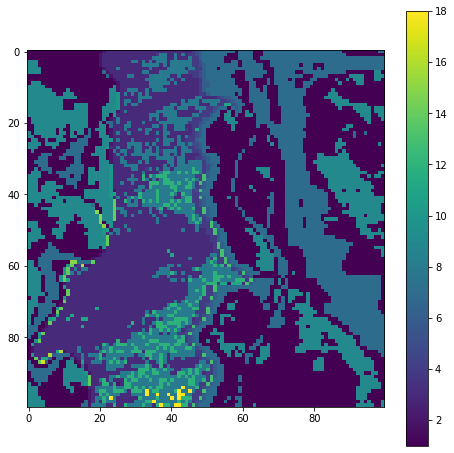

In [195]:
plt.figure(figsize = (8, 8))
plt.imshow( mask_hsi.reshape(open_hsi.ncols, open_hsi.ncols) )
plt.colorbar()

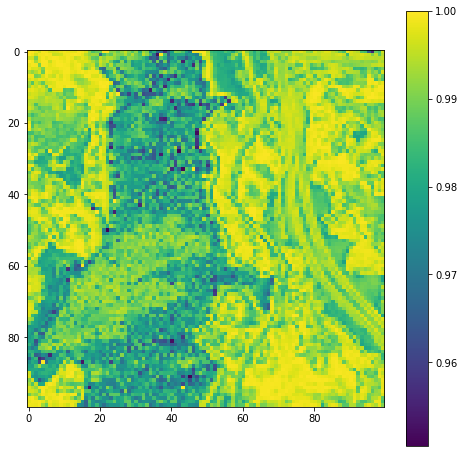

In [198]:
plt.figure(figsize = (8, 8))
plt.imshow( mask_values.reshape(open_hsi.ncols, open_hsi.ncols) )
plt.colorbar()

In [128]:
@jit(nopython = True)
def angle_between_vecs_numba(vec_1, vec_2):
    dot = 0
    sqrt_1 = 0
    sqrt_2 = 0
    for i in range(vec_1.shape[0]):
        dot = dot + (vec_1[i] * vec_2[i])
        sqrt_1 = sqrt_1 + (vec_1[i] * vec_1[i])
        sqrt_2 = sqrt_2 + (vec_2[i] * vec_2[i])
    return dot / ( pow(sqrt_1, 0.5) * pow(sqrt_2, 0.5) )

@jit(nopython = True)
def arg_max_compliance(pix, sig_clusters, threshold_clusters):
    max_e = 0
    max_i = -1
    
    for i in range(len(sig_clusters)):        
        difference = angle_between_vecs_numba(sig_clusters[i], pix) -  threshold_clusters[i]
        if max_e < difference:
            max_e = difference
            max_i = i
    return max_e, max_i

def reference_clustering(HSI, threshold = 0.90, clusters = [], value_mask_on = False, rgb_image = False):
    
    HSI = np.array(HSI)
    rgb_image = np.array(rgb_image)
    
    amo_of_pix = HSI.shape[0]
    len_pix = HSI.shape[1]
    cluster_mask = np.int16( np.zeros(shape = amo_of_pix) )
    cluster_mask_color = np.int16( np.zeros(shape = (amo_of_pix, 3)) )
    if value_mask_on:
        value_mask = np.zeros(shape = amo_of_pix)
            
    if len(clusters) == 0:
        signatures = np.zeros(shape = (1, len_pix))
        amo_of_pix_clusts = np.zeros(shape = 1)
        thresholds = np.zeros(shape = 1)
        cluster_mask[0] = 1
        
        nn_pix = 0
        while all(HSI[nn_pix] != HSI[nn_pix][0]):
            nn_pix = nn_pix + 1
        signatures[0] = HSI[nn_pix]
        
        amo_of_pix_clusts[0] = 1
        thresholds[0] = threshold
        start_clust = 1
        if value_mask_on:
            value_mask[0] = 1
    else:
        signatures = clusters[0]
        amo_of_pix_clusts = clusters[1]
        thresholds = clusters[2]
        start_clust = 0
        for amount in amo_of_pix_clusts:
            amount = 0
    
    print(amo_of_pix)
    for i in range(start_clust, amo_of_pix):
        
        if all(HSI[i] == HSI[i][0]):
            continue

        max_difference, class_number = arg_max_compliance(HSI[i], signatures, thresholds)
        
        if max_difference > 0:
            cluster_mask[i] = class_number + 1
            amo_of_pix_clusts[class_number] = amo_of_pix_clusts[class_number] + 1
            if value_mask_on:
                value_mask[i] = max_difference + thresholds[class_number]
        else:
            cluster_mask[i] = signatures.shape[0] + 1
            signatures = np.append(signatures, [HSI[i]], axis = 0)
            amo_of_pix_clusts = np.append(amo_of_pix_clusts, 1)
            thresholds = np.append(thresholds, threshold)
            if value_mask_on:
                value_mask[i] = 1.0
                
        if i % 1000 == 0:
            print('\r', end = '')
            print(i,  end = '')
    
    for i in range(len(signatures)):
        for col in range(3):
            cluster_mask_color[cluster_mask == i + 1, col] = rgb_image[cluster_mask == i + 1, col].mean()
    
    clusters = [signatures, amo_of_pix_clusts, thresholds]

    print('\n')
    print("nclass", len(clusters[0]))
    if value_mask_on:
        return cluster_mask, cluster_mask_color, clusters, value_mask
    else:
        return cluster_mask, cluster_mask_color, clusters


def all_stat(hsi, mask, num_clust):
    num_pix_clust = np.nonzero(mask == num_clust)[0]
    mean_sig = np.zeros(shape = hsi.shape[1])
    std_sig = np.zeros(shape = hsi.shape[1])
    min_sig = np.zeros(shape = hsi.shape[1])
    max_sig = np.zeros(shape = hsi.shape[1])
    
    for i in range(hsi.shape[1]):
        mean_sig[i] = hsi[num_pix_clust, i].mean()
        std_sig[i] = hsi[num_pix_clust, i].std()
        min_sig[i] = hsi[num_pix_clust, i].min()
        max_sig[i] = hsi[num_pix_clust, i].max()
        
    return mean_sig, std_sig, min_sig, max_sig


def seg_clust_for_mean(hsi, mask, mean, num_clust, intervals, rgb_pic):
    angles_between_men = np.zeros( shape = hsi.shape[0] )
    for i, sig in enumerate(hsi):
        angles_between_men[i] = angle_between_vecs_numba(sig, mean)
    
    plt.figure(figsize=(15, 7))
    h = plt.hist(angles_between_men[mask == num_clust], 1000)
    plt.grid(True)
    plt.xlabel('значения отклонения от среднего', fontsize = 18)
    plt.ylabel('количество пикселей с данным отклонением', fontsize = 18)
    
    intervals = np.insert(intervals, 0, h[1][0])
    intervals = np.append(intervals, h[1][-1])
    rgb_color_clust = np.zeros(shape = (intervals.shape[0] - 1, 3))
    for i in range(intervals.shape[0] - 1):
        for c in range(3):
            rgb_color_clust[i, c] = rgb_pic[ (angles_between_men >= intervals[i]) &
                                             (angles_between_men < intervals[i + 1]) &
                                             (mask == num_clust), c].mean()
    rgb_color_clust = np.int16(rgb_color_clust * 2)
    
    col_norm = rgb_color_clust / 255
    plt.plot([intervals[0], intervals[0]], [0, h[0].max()], color = col_norm[0], linewidth = 4)
    plt.text(intervals[0], h[0].max(), np.float16(intervals[0]))
    plt.plot([intervals[-1], intervals[-1]], [0, h[0].max()], color = 'black', linewidth = 4)
    plt.text(intervals[-1], h[0].max(), np.float16(intervals[-1]))

    for i in range(1, intervals.shape[0] - 1):
        col = np.array(rgb_color_clust[i]) / 255
        plt.plot([intervals[i], intervals[i]], [0, h[0].max()], color = col_norm[i], linewidth = 4)
        plt.text(intervals[i], h[0].max(), intervals[i])
       
    pic_sep_color_clust = np.zeros(shape = (mask.shape[0], 3))
    
    for i in range(intervals.shape[0] - 1):
        pic_sep_color_clust[ (angles_between_men >= intervals[i]) & (angles_between_men < intervals[i + 1]) & (mask == num_clust) ] = rgb_color_clust[i]    
        num_of_pix = pic_sep_color_clust[ (angles_between_men >= intervals[i]) & (angles_between_men < intervals[i + 1]) & (mask == num_clust) ].shape[0]
        plt.text(intervals[i], h[0].max() - (h[0].max() * 0.08), str(num_of_pix) + '\n пикселей')
    
    fh.show_1D_img(pic_sep_color_clust, 1924, 753, _show_x = 30, _show_y = 40, flip = True)
    return pic_sep_color_clust


def seg_clust(hsi, mask, mask_v, num_clust, intervals, rgb_pic):
    clust_values = mask_v[mask == num_clust]
    plt.figure(figsize=(15, 7))
    h = plt.hist(clust_values, 1000)
    plt.grid(True)
    plt.xlabel('значения отклонения от среднего', fontsize = 18)
    plt.ylabel('количество пикселей с данным отклонением', fontsize = 18)

    intervals = np.insert(intervals, 0, h[1][0])
    intervals = np.append(intervals, h[1][-1])
    rgb_color_clust = np.zeros(shape = (intervals.shape[0] - 1, 3))
    for i in range(intervals.shape[0] - 1):
        rgb_color_clust[i, 0] = rgb_pic[ (mask_v >= intervals[i]) & (mask_v < intervals[i + 1]) & (mask == num_clust), 0].mean()
        rgb_color_clust[i, 1] = rgb_pic[ (mask_v >= intervals[i]) & (mask_v < intervals[i + 1]) & (mask == num_clust), 1].mean()
        rgb_color_clust[i, 2] = rgb_pic[ (mask_v >= intervals[i]) & (mask_v < intervals[i + 1]) & (mask == num_clust), 2].mean()
    rgb_color_clust = np.int16(rgb_color_clust * 2)
    
    col_norm = rgb_color_clust / 255
    plt.plot([intervals[0], intervals[0]], [0, h[0].max()], color = col_norm[0], linewidth = 4)
    plt.text(intervals[0], h[0].max(), np.float16(intervals[0]))
    plt.plot([intervals[-1], intervals[-1]], [0, h[0].max()], color = 'black', linewidth = 4)
    plt.text(intervals[-1], h[0].max(), np.float16(intervals[-1]))

    for i in range(1, intervals.shape[0] - 1):
        col = np.array(rgb_color_clust[i]) / 255
        plt.plot([intervals[i], intervals[i]], [0, h[0].max()], color = col_norm[i], linewidth = 4)
        plt.text(intervals[i], h[0].max(), intervals[i])
        
    pic_sep_color_clust = np.zeros(shape = (mask.shape[0], 3))
    
    for i in range(intervals.shape[0] - 1):
        pic_sep_color_clust[ (mask_v >= intervals[i]) & (mask_v < intervals[i + 1]) & (mask == num_clust) ] = rgb_color_clust[i]    
        num_of_pix = pic_sep_color_clust[ (mask_v >= intervals[i]) & (mask_v < intervals[i + 1]) & (mask == num_clust) ].shape[0]
        plt.text(intervals[i], h[0].max() - (h[0].max() * 0.08), str(num_of_pix) + '\n пикселей')
    
    fh.show_1D_img(pic_sep_color_clust, 1924, 753, _show_x = 30, _show_y = 40, flip = True)
    return pic_sep_color_clust